In [3]:
from skimage.measure import label
import optuna
import cellseg.src.image_worker as iw
import cellseg.src.convert_worker as cw
import mahotas as mh
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import numpy as np

/home/petka/projects/UJEP/bakalarka/segmentace-bunek/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
img_unsharp = iw.unsharp_mask_img(img, radius=20, percent=300, threshold=0.5)
r1, g1, b1 = img_unsharp[:, :, 0], img_unsharp[:, :, 1], img_unsharp[:, :, 2]

b_bin_otsu = cw.convert_grayscale_to_bin_otsu(b1)
b_bin_otsu_morp = iw.close_holes_remove_noise(b_bin_otsu, mask_size=5, iterations=6)

img_labeled_nuclei, nr_nuclei = mh.label(b_bin_otsu_morp)
img_labeled_nuclei = iw.remove_small_regions(img_labeled_nuclei, min_size=100)

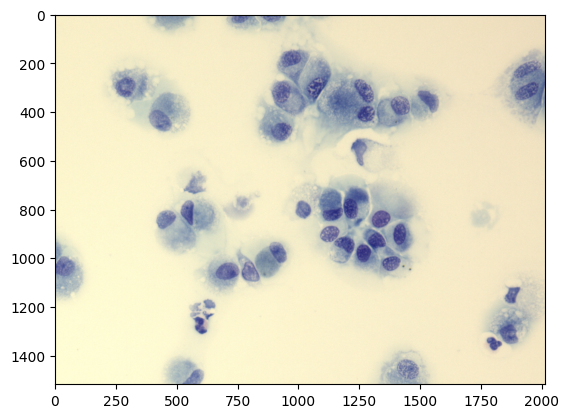

In [4]:
img = mh.imread("Images/all_images/2023_12_14_image_006.png")

width = img.shape[1]
height = img.shape[0]

plt.imshow(img)

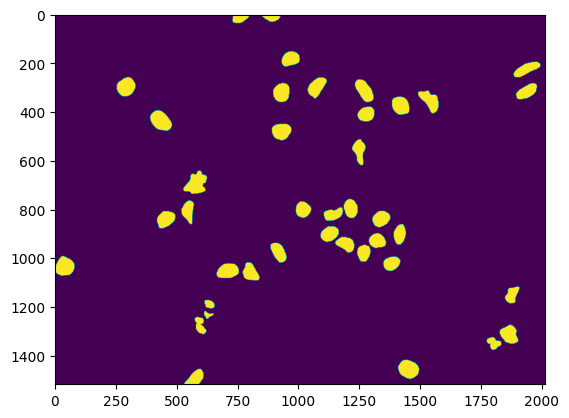

In [2]:
label = np.load("Labels/orig/nucleus/2023_12_14_image_006.npy")

plt.imshow(label)

In [4]:
imgs_dir = Path("Images/all_images")

for img_path in imgs_dir.glob("*.png"):
    img = mh.imread(img_path)

NameError: name 'Path' is not defined

In [4]:
from pathlib import Path
from skimage.measure import label
import optuna
import cellseg.src.image_worker as iw
import cellseg.src.convert_worker as cw
import mahotas as mh
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import numpy as np
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from scipy.ndimage import distance_transform_edt
import scipy.ndimage as ndi

def objective(trial):
    
    imgs_dir = Path("cellseg/Images/all_images/")
    
    radius = trial.suggest_int("radius", 1, 100)
    percent = trial.suggest_int("percent", 1, 1000)
    threshold = trial.suggest_int("threshold", 1, 10)
    mask_size = trial.suggest_int("mask_size", 1, 10)
    iterations = trial.suggest_int("iterations", 1, 10)
    min_size = trial.suggest_int("min_size", 1, 100)
    
    scores = []
    
    for img_path in imgs_dir.glob("*.png"):
        img = mh.imread(img_path)
        label_img = np.load("cellseg/Labels/orig/nucleus/" + img_path.stem + ".npy")
        
        img_unsharp = iw.unsharp_mask_img(img, radius=radius, percent=percent, threshold=threshold)
        r1, g1, b1 = img_unsharp[:, :, 0], img_unsharp[:, :, 1], img_unsharp[:, :, 2]
        
        b_bin_otsu = cw.convert_grayscale_to_bin_otsu(b1)
        b_bin_otsu_morp = iw.close_holes_remove_noise(b_bin_otsu, mask_size=mask_size, iterations=iterations)
        
        b_bin_otsu_morp = iw.remove_small_regions(b_bin_otsu_morp, min_size=min_size)
        
        f1 = f1_score(label_img.flatten(), b_bin_otsu_morp.flatten())
        
        scores.append(f1)
    
    return np.mean(scores)

In [ ]:
study = optuna.create_study(
    storage="sqlite:///params.db",
    load_if_exists=True,
    study_name="nucleis_segmentation",
    direction="maximize",
    
)
study.optimize(objective, n_trials=500)
# "radius":
# 32
# "percent":
# 852
# "threshold":
# 7
# "mask_size":
# 3
# "iterations":
# 5
# "min_size":
# 60

[I 2024-12-03 18:34:58,804] A new study created in RDB with name: nucleis_segmentation
[I 2024-12-03 18:35:46,344] Trial 0 finished with value: 0.6894555223738114 and parameters: {'radius': 62, 'percent': 121, 'threshold': 5, 'mask_size': 1, 'iterations': 3, 'min_size': 5}. Best is trial 0 with value: 0.6894555223738114.
[I 2024-12-03 18:36:39,311] Trial 1 finished with value: 0.7915504060221109 and parameters: {'radius': 41, 'percent': 775, 'threshold': 10, 'mask_size': 3, 'iterations': 7, 'min_size': 25}. Best is trial 1 with value: 0.7915504060221109.
[I 2024-12-03 18:37:42,456] Trial 2 finished with value: 0.25748659024700316 and parameters: {'radius': 83, 'percent': 587, 'threshold': 10, 'mask_size': 8, 'iterations': 9, 'min_size': 12}. Best is trial 1 with value: 0.7915504060221109.
[I 2024-12-03 18:38:37,495] Trial 3 finished with value: 0.7827145174837977 and parameters: {'radius': 35, 'percent': 612, 'threshold': 1, 'mask_size': 2, 'iterations': 10, 'min_size': 98}. Best is tr